In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import h5py
from tqdm import tqdm
import yaml
import k3d

import sys
sys.path.append('sharp_features-feature-defrag_shuffle_split_hdf5/')

from sharpf.data.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK, MergedABCItem

In [2]:
import numpy as np
import trimesh.transformations as tt


def rotate_to_world_origin(camera_origin):
    # construct a 3x3 rotation matrix to a coordinate frame where:
    # Z axis points to world origin aka center of a mesh
    # Y axis points down
    # X axis is computed as Y cross Z

    camera_origin = np.asanyarray(camera_origin)

    e_z = -camera_origin / np.linalg.norm(camera_origin)  # Z axis points to world origin aka center of a mesh
    e_y = np.array([0, 0, -1])  # proxy to Y axis pointing directly down
    # note that real e_y must be
    # 1) orthogonal to e_z;
    # 2) lie in the plane spanned by e_y and e_z;
    # 3) point downwards so <e_y, [0, 0, -1]> >= <e_y, [0, 0, +1]>
    # 4) unit norm
    gamma = np.dot(e_y, e_z)
    e_y = -gamma / (1 + gamma ** 2) * e_z + 1. / (1 + gamma ** 2) * e_y
    if np.dot(e_y, [0, 0, -1]) < np.dot(e_y, [0, 0, 1]):
        e_y *= -1
    e_y /= np.linalg.norm(e_y)
    e_x = np.cross(e_y, e_z)  # X axis
    R = np.array([e_x, e_y, e_z])
    return R


def create_rotation_matrix_z(rz):
    return np.array([[np.cos(rz), -np.sin(rz), 0.0],
                     [np.sin(rz), np.cos(rz), 0.0],
                     [0.0, 0.0, 1.0]])


def camera_to_display(image):
    return image[::-1, ::-1].T


class CameraPose:
    def __init__(self, transform):
        self._camera_to_world_4x4 = transform
        # always store transform from world to camera frame
        self._world_to_camera_4x4 = np.linalg.inv(self._camera_to_world_4x4)

    @classmethod
    def from_camera_to_world(cls, rotation=None, translation=None):
        """Create camera pose from camera to world transform.
        :param rotation: 3x3 rotation matrix of camera frame axes in world frame
        :param translation: 3d location of camera frame origin in world frame
        """
        rotation = np.identity(3) if None is rotation else np.asanyarray(rotation)
        translation = np.zeros(3) if None is translation else np.asanyarray(translation)

        transform = np.identity(4)
        transform[:3, :3] = rotation
        transform[:3, 3] = translation

        return cls(transform)

    @classmethod
    def from_camera_axes(cls, R=None, t=None):
        """Compute 4x4 camera pose from camera axes given in world frame.
        :param R: a list of 3D basis vectors (cx, cy, cz) defined in world frame
        :param t: 3D vector defining location of camera origin in world frame
        """
        if None is R:
            R = np.identity(3)

        return cls.from_camera_to_world(rotation=R.T, translation=t)

    def world_to_camera(self, points):
        """Transform points from world to camera coordinates.
        Useful for understanding where the objects are, as seen by the camera.
        :param points: either n * 3 array, or a single 3-vector
        """
        points = np.atleast_2d(points)
        return tt.transform_points(points, self._world_to_camera_4x4)

    def camera_to_world(self, points, translate=True):
        """Transform points from camera to world coordinates.
        Useful for understanding where objects bound to camera
        (e.g., image pixels) are in the world.
        :param points: either n * 3 array, or a single 3-vector
        :param translate: if True, also translate the points
        """
        points = np.atleast_2d(points)
        return tt.transform_points(points, self._camera_to_world_4x4, translate=translate)

    @property
    def world_to_camera_4x4(self):
        return self._world_to_camera_4x4

    @property
    def camera_to_world_4x4(self):
        return self._camera_to_world_4x4

    @property
    def frame_origin(self):
        """Return camera frame origin in world coordinates."""
        return self.camera_to_world_4x4[:3, 3]

    @property
    def frame_axes(self):
        """Return camera axes: a list of 3D basis
        vectors (cx, cy, cz) defined in world frame"""
        return self.camera_to_world_4x4[:3, :3].T

    def compose_world_to_camera(self, other_pose):
        """Compose camera poses C_1, C_2, ... (defined relative to each other),
        computing transforms from world frame to an innermost camera frame.
        Equivalent to:
        x_world = <some point>
        other_pose.world_to_camera(
            pose.world_to_camera(
                x_world
            )
        )
        """
        composed_world_to_camera_4x4 = np.dot(other_pose.world_to_camera_4x4, self._world_to_camera_4x4)
        composed_camera_to_world_4x4 = np.linalg.inv(composed_world_to_camera_4x4)
        return CameraPose(composed_camera_to_world_4x4)

    def compose_camera_to_world(self, other_pose):
        """Compose camera poses C_1, C_2, ... (defined relative to each other),
        computing transforms from innermost camera frame to the world frame.
        Equivalent to:
        x_local = <some point>
        pose.camera_to_world(
            pose_local.camera_to_world(
                x_local
            )
        )
        """
        composed_camera_to_world_4x4 = np.dot(self._camera_to_world_4x4, other_pose.camera_to_world_4x4, )
        return CameraPose(composed_camera_to_world_4x4)

In [3]:
with h5py.File('data/images/val/train_0.hdf5', 'r') as f:
    data = f['image'][:]
    distances = f['distances'][:]
    item_ids = f['item_id'][:]
    cameras = f['camera_pose'][:]
    mesh_scales = f['mesh_scale'][:]

In [4]:
ind = np.where((data.reshape(-1,4096) != 0).all(-1))[0] # select depths with no background
ind.shape

(8980,)

In [5]:
sample = 1256
depth_image = data[ind][sample]
distance = distances[ind][sample]
item_id = item_ids[ind][sample]
chunk_id = item_id.decode().split('_')[0][:4]
camera = cameras[ind][sample]
scale = mesh_scales[ind][sample]

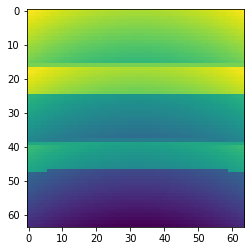

In [6]:
plt.imshow(depth_image)

In [7]:
# prepare coordinates for depth to point cloud transfer
image_height, image_width = 64, 64
resolution_3d = 0.02
screen_aspect_ratio = 1

rays_screen_coords = np.mgrid[0:image_height, 0:image_width].reshape(
        2, image_height * image_width).T

rays_origins = (rays_screen_coords / np.array([[image_height, image_width]]))   # [h, w, 2], in [0, 1]
factor = image_height / 2 * resolution_3d
rays_origins[:, 0] = (-2 * rays_origins[:, 0] + 1) * factor  # to [-1, 1] + aspect transform
rays_origins[:, 1] = (-2 * rays_origins[:, 1] + 1) * factor * screen_aspect_ratio
rays_origins = np.concatenate([
    rays_origins,
    np.zeros_like(rays_origins[:, [0]])
], axis=1)

In [8]:
def image_to_points(image, rays_origins):
        i = np.where(image.ravel() != 0)[0]
        points = np.zeros((len(i), 3))
        points[:, 0] = rays_origins[i, 0]
        points[:, 1] = rays_origins[i, 1]
        points[:, 2] = image.ravel()[i]
        return points

In [9]:
point_cloud = image_to_points(depth_image, rays_origins) # convert depth to point cloud

In [10]:
point_cloud

array([[ 0.64      ,  0.64      ,  4.25495966],
       [ 0.64      ,  0.62      ,  4.25180351],
       [ 0.64      ,  0.6       ,  4.24872911],
       ...,
       [-0.62      , -0.58      ,  3.88875483],
       [-0.62      , -0.6       ,  3.89170243],
       [-0.62      , -0.62      ,  3.89465002]])

In [11]:
# load the mesh and its features from ABC (takes some time)
from sharpf.utils.mesh_utils.io import trimesh_load
with ABCChunk(['/gpfs/gpfs0/3ddl/datasets/abc/abc_{chunk}_obj_v00.7z'.format(chunk=chunk_id)]) as chunk:
        file_in_chunk = chunk.get_one(item_id.decode())
        mesh = trimesh_load(file_in_chunk.obj)
        
with ABCChunk(['/gpfs/gpfs0/3ddl/datasets/abc/abc_{chunk}_feat_v00.7z'.format(chunk=chunk_id)]) as chunk:
        file_in_chunk = chunk.get_one(item_id.decode())
        feat = yaml.load(file_in_chunk.feat, Loader=yaml.Loader)['curves']
        sharp_lines = []
        for i in feat:
            if ('sharp' in i.keys() and i['sharp'] == True):
                line_indices = []
                for j in i['vert_indices']:
                    line_indices.append(j)
                sharp_lines.append(line_indices)

In [12]:
mesh.show()

In [13]:
camera_pose = CameraPose(camera)

In [14]:
# scale the mesh
mesh_scaled = mesh.copy().apply_scale(10 / np.max(mesh.bounding_box.extents))
mesh_scaled = mesh_scaled.apply_scale(scale)
mesh_scaled = mesh_scaled.apply_translation(-mesh_scaled.vertices.mean(axis=0))

In [15]:
def get_colors(pred, cmap):
    hex_colors = []
    norm = mpl.colors.Normalize(vmin=-1, vmax=0)
    cmap = cmap
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in pred:
        hex_colors.append(int(mpl.colors.to_hex(m.to_rgba(i)).replace('#','0x'),16))
    hex_colors = np.array(hex_colors, 'uint32')
    return(hex_colors)

In [16]:
sharp_lines_coords = []
for line_indices in sharp_lines:
    sharp_lines_coords.append(mesh_scaled.vertices[line_indices])

p = k3d.plot()

pc_color = get_colors(-distance.flatten(), cm.coolwarm)

k3d_mesh = k3d.mesh(mesh_scaled.vertices, mesh_scaled.faces, color=0xdfdff7)

k3d_points = k3d.points(camera_pose.camera_to_world(point_cloud, translate=True), point_size=0.02, colors=pc_color)

p += k3d_points + k3d_mesh

for line_coords in sharp_lines_coords:
    line = k3d.line(line_coords, shader='mesh', width=0.01, color=16711680)
    p += line

/trinity/home/a.matveev/.local/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/trinity/home/a.matveev/.local/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [17]:
f = open("depth.html", 'w')
f.write(p.get_snapshot())
f.close()